In [23]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd

### Model Preparation

In [24]:
unique_labels = ['White', 'Black', 'Asian', 'Indian']

In [25]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, len(unique_labels))

    def forward(self, x):
        return self.resnet(x)

In [26]:
net = ResNet()
lr = 0.01
nb_epochs = 30
batch_size = 64
seed = 777
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### Data Preparation

In [27]:
!unzip data.zip -d ./data

Archive:  data.zip
replace ./data/utk_race_cc1_seed777/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:


#%% Define transformations
train_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.RandomCrop(104),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.CenterCrop(size=104),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

#%% Load datasets and apply transformations
train_dataset = ImageFolder('data/utk_race_cc1_seed{}/train/'.format(seed), transform=train_transform)
val_dataset = ImageFolder('data/utk_race_cc1_seed{}/val/'.format(seed), transform=test_transform)
test_dataset = ImageFolder('data/utk_race_cc1_seed{}/test/'.format(seed), transform=test_transform)

#%% Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

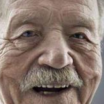

In [29]:
inv_normalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                    std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                    transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                    std = [ 1., 1., 1. ]),
                                  ])

input_tensor = inv_normalize(train_dataset[0][0])
grid = torchvision.utils.make_grid(input_tensor, nrow=1)
transforms.ToPILImage()(grid)

### Training

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()

In [31]:
loss_train = np.zeros(nb_epochs+1)
loss_val= np.zeros(nb_epochs+1)


In [32]:
print("training...")

print(net)

net.train()
for epoch in range(1, nb_epochs + 1):
    train_loss = []
    val_loss = []
    patience = 0

    best_val_loss = 999

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        loss = loss_fn(net(x), y)
        loss.backward()

        optimizer.step()
        # lr_scheduler.step()

        train_loss.append(loss.item())


    net.eval()
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)

        loss = loss_fn(net(x), y)

        val_loss.append(loss.item())

    print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, np.mean(train_loss), np.mean(val_loss)))
    loss_train[epoch] = np.mean(train_loss)
    loss_val[epoch] = np.mean(val_loss)


    if best_val_loss - np.mean(val_loss) > 0.01:
        best_val_loss = np.mean(val_loss)
        patience = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, './outputs/best_model.pth')
        print("val_loss improved. Saved best model")

training...
ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

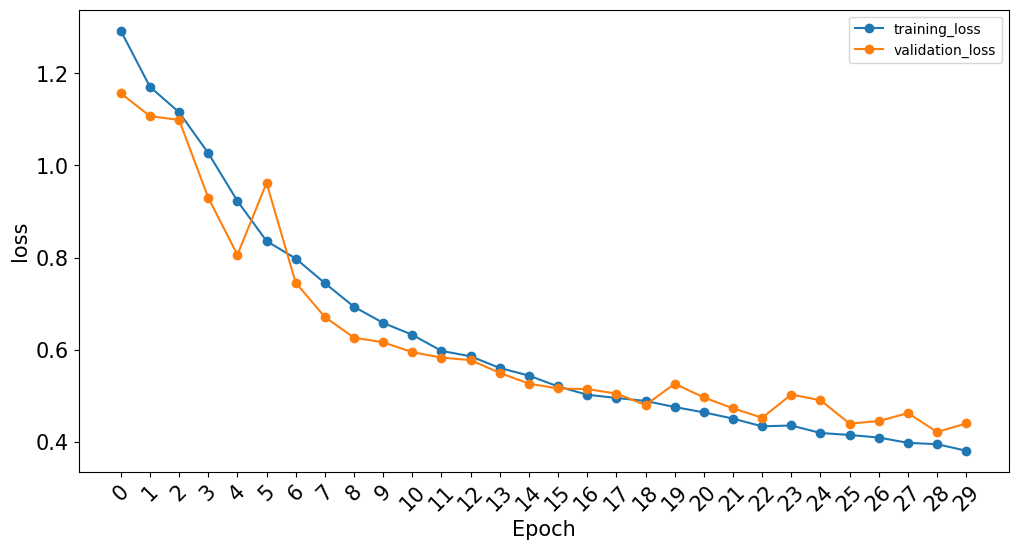

In [33]:
#saving and plotting the loss values
df = pd.DataFrame({
    'epoch':range(1,nb_epochs+1),
    'training_loss':loss_train[1:nb_epochs+1],
    'validation_loss':loss_val[1:nb_epochs+1]
})
df
ax= df.iloc[0:].plot(y=['training_loss','validation_loss'],figsize= (12,6),xticks=df.index, fontsize=15,marker ='o', rot = 45)
ax.set_ylabel('loss',fontsize=15)
ax.set_xlabel('Epoch',fontsize=15)
plt.savefig('loss.jpg')
plt.show()
df.to_csv('loss.csv')

### Evaluation

In [34]:
net = ResNet()
net.load_state_dict(torch.load('./outputs/best_model.pth')['model_state_dict'])
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()
print("loaded best model")

loaded best model


In [35]:
net.eval()
ys = []
y_preds = []

for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    y_pred = net(x)

    ys.append(y.detach().cpu().data.numpy())
    y_preds.append(y_pred.detach().cpu().data.numpy())

In [36]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [37]:
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       980
           1       0.87      0.83      0.85       485
           2       0.86      0.81      0.83       324
           3       0.71      0.80      0.75       412

    accuracy                           0.84      2201
   macro avg       0.83      0.83      0.83      2201
weighted avg       0.84      0.84      0.84      2201



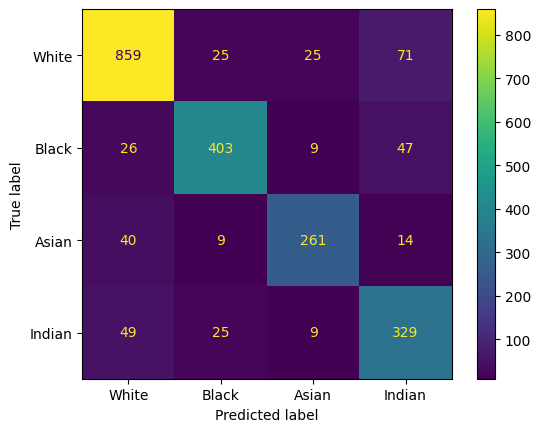

In [38]:
cnf_matrix = confusion_matrix(ys,y_preds,labels=[0,1,2,3])
np.set_printoptions(precision=2)


disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels= ['White', 'Black', 'Asian', 'Indian'])
disp.plot()
plt.show()

array([0, 0, 0, ..., 0, 1, 2])